In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - Jiang et al

In [2]:
x = torch.from_numpy(
    np.load("../hydro-interpretive-dl/jiang_et_al_xtrain.npy")
).float()
y = torch.from_numpy(
    np.load("../hydro-interpretive-dl/jiang_et_al_ytrain.npy")
).float()

x = x[:100]
y = y[:100]

x.shape, y.shape

(torch.Size([100, 180, 2]), torch.Size([100, 1]))

# Define a simple model

In [3]:
import torch
import torch.nn as nn


# Simple LSTM made from scratch
class LSTMDA(nn.Module):
    def __init__(self, input_dim, hidden_dim, recur_dropout = 0, dropout = 0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        # See the file "neuralnet_math_README.md" in the root directory for
        # equations and implementation details
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()
        
        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)
        
        self.dense = nn.Linear(hidden_dim, 1)
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
        
    def forward(self, x, init_states = None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
        
        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * self.recur_dropout(g_t)
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim= 1)
        hidden_out = hidden_seq[:, -1, :] # changed, dont return whole hidden sequence for dense layer
        out = self.dense(hidden_out)
        return out # changed, dont return states

model = LSTMDA(2, 16)

In [4]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

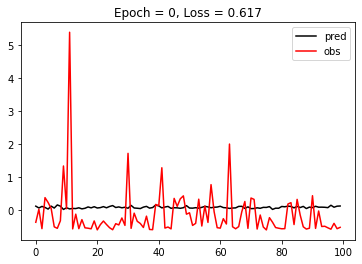

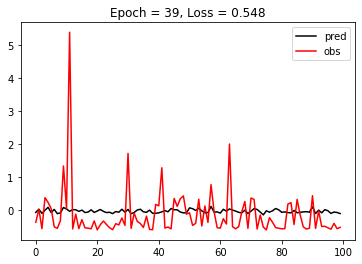

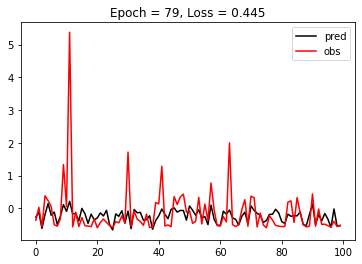

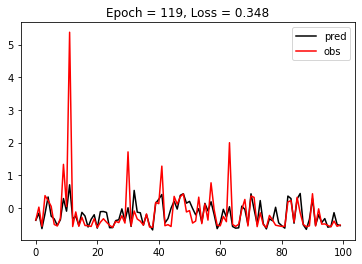

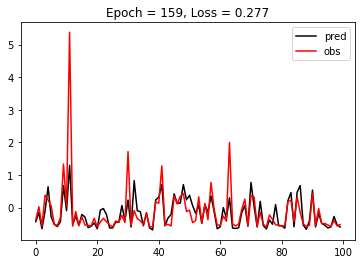

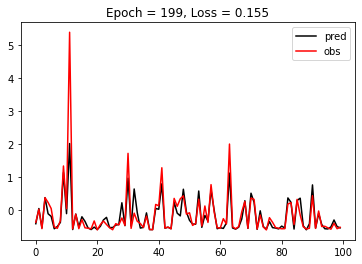

In [5]:
for i in range(200):
    out = model(x)
    loss = loss_fn(out, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 40 == 0 or i == 0:
        plt.plot(out.detach(), color = 'black', label = 'pred')
        plt.plot(y, color = 'red', label = 'obs')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.show()
        plt.pause(0.001)

# Apply XAI

In [6]:
from captum.attr import IntegratedGradients

In [7]:
ig = IntegratedGradients(model)

In [8]:
integrated_gradients = ig.attribute(x)

### Explore visualization options

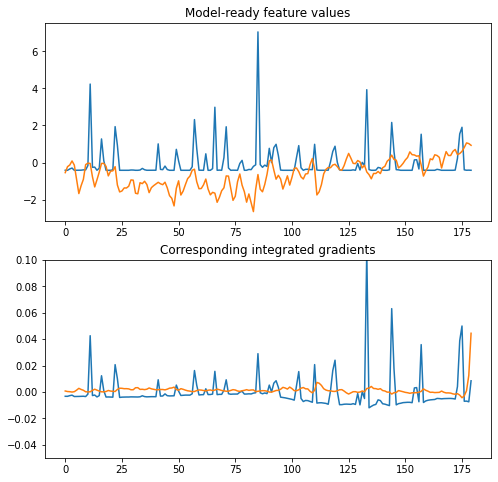

In [9]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))
ax[0].plot(x[0, :])
ax[0].set_title('Model-ready feature values')
ax[1].plot(integrated_gradients[0, :])
ax[1].set_title('Corresponding integrated gradients')
ax[1].set_ylim(-0.05, 0.1);

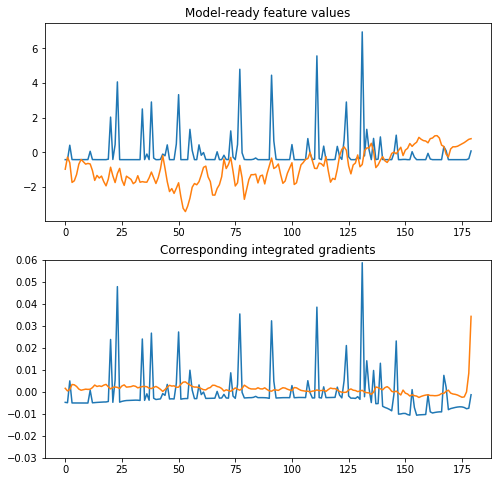

In [10]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

index = np.random.choice(len(x))

ax[0].plot(x[index, :])
ax[0].set_title('Model-ready feature values')
ax[1].plot(integrated_gradients[index, :])
ax[1].set_title('Corresponding integrated gradients')
ax[1].set_ylim(-0.03, 0.06);